In [225]:
import os
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

In [226]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [295]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import Trajectory, select_nodes
from statmechlib.forcefields import utot_EAM_per_atom, utot_EAM_per_box, udif_print, u_core

In [296]:
target_proc = '../data/target_processed'
working = '../data/working'
reports = '../reports'

In [297]:
params_file = 'marinica_params'
stats_file = 'stats_marinica'
target_file = 'target_marinica'
stats_file = 'stats_manyknots' # 'stats_samples'
target_file = 'target_manyknots' # 'target_samples'
params_file = 'marinica_params'

In [298]:
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_all = pickle.load(fi)

with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi)

with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
    param_list = pickle.load(fi)  

In [299]:
def find_index(select_list, full_list):
    knots = []
    for sel in select_list:
        for i, elem in enumerate(full_list):
            if abs(sel - elem) < 1e-9:
                knots.append(i)
                break
    
    assert len(knots) == len(select_list), "Knots and select_list lengths do not match"
    
    return knots

In [355]:
type(stats_all['md']['energy'])#.keys()

list

In [300]:
# extended knots
pair_knots = [ 2.45, 2.5648975,  2.629795 ,  2.6946925,  2.8663175,  2.973045 ,
        3.0797725,  3.5164725,  3.846445 ,  4.1764175,  4.700845 ,
        4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,  5.4604375, 5.78]
edens_knots = [ 2.5,  3.1,  3.5,  4.9, 5.5]

pair_index = find_index(pair_knots, stats_all['hyperparams']['pair'])
edens_index = find_index(edens_knots, stats_all['hyperparams']['edens'])
print('pair_index:', pair_index)
print('edens_index:', edens_index)

('pair_index:', [2, 6, 9, 11, 17, 20, 24, 36, 45, 54, 69, 74, 80, 88, 90, 93, 101])
('edens_index:', [4, 25, 35, 75, 94])


In [301]:
# selecty spline knots
#pair_index = [1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 15, 16, 17, 18]
#multibody_index = [0, 7, 8, 14]

p_ix = np.array([True if i in pair_index else False for i in range(len(stats_all['hyperparams']['pair']))])
m_ix = np.array([True if i in edens_index else False for i in range(len(stats_all['hyperparams']['edens']))])

stats = select_nodes(stats_all, p_ix, m_ix)

print("pair:", np.array(stats_all['hyperparams']['pair'])[p_ix])
print("edens:", np.array(stats_all['hyperparams']['edens'])[m_ix])
print('pars', param_list[0]['hyperparams'])

('pair:', array([ 2.45     ,  2.5648975,  2.629795 ,  2.6946925,  2.8663175,
        2.973045 ,  3.0797725,  3.5164725,  3.846445 ,  4.1764175,
        4.700845 ,  4.8953   ,  5.089755 ,  5.3429525,  5.401695 ,
        5.4604375,  5.78     ]))
('edens:', array([ 2.5,  3.1,  3.5,  4.9,  5.5]))
('pars', {u'pair': [2.5648974999999998, 2.6297950000000001, 2.6946924999999999, 2.8663175000000001, 2.9730449999999999, 3.0797724999999998, 3.5164724999999999, 3.8464450000000001, 4.1764175000000003, 4.7008450000000002, 4.8952999999999998, 5.0897550000000003, 5.3429525, 5.4016950000000001, 5.4604375000000003], u'edens': [2.5, 3.1, 3.5, 4.9]})


In [342]:
optimal_params = []
for params in param_list:
    #eam_params = list(params['params']['embed']) + list(params['params']['pair']) + list(params['params']['edens'])
    eam_params = list(params['params']['embed']) + [0.0] + list(params['params']['pair']) + [0.0] + list(params['params']['edens']) + [0.0]
    optimal_params.append((0.0, np.array(eam_params)))

In [343]:
#optimal_params.append((3.0674198658721691e-06, np.array([ -8.15036857e+00,  -1.34492508e-01,  -6.40562492e+02,
#         5.60045606e+02,  -1.62774419e+02,  -2.42163837e+01,
#         4.61349632e+01,  -1.21579989e+01,   6.09852042e-01,
#         1.39564841e+00,  -1.26608655e+00,  -7.44806685e-01,
#         2.00404873e+00,  -6.91376693e-01,   2.17652121e-02,
#        -1.61632910e+00,   1.37087609e+00,  -3.76175083e+01,
#         1.56626002e+00,  -1.74622706e-01,   3.14905374e-02])))
#optimal_params.append((2.2036185726499669e-06, np.array([ -6.70205913e+00,  -3.86729923e-02,  -6.36660911e+02,
#         7.48522323e+02,  -3.02289981e+02,   2.43903738e+01,
#         7.99267764e+00,  -5.00288982e+00,   3.98363657e-01,
#         1.18177686e+00,  -1.04440728e+00,  -7.34361783e-01,
#         2.03940754e+00,  -7.33324453e-01,   3.22601497e-02,
#        -1.68659097e+00,   1.39384190e+00,  -2.87086061e+01,
#         6.41466635e-01,  -5.25140182e-02,   3.13551914e-02])))
#optimal_params.append((1.9883954014792284e-06, np.array([ -6.67892458e+00,  -6.69057233e-02,  -7.88558288e+02,
#         8.64431119e+02,  -3.22117669e+02,   1.66223488e+01,
#         1.61253439e+01,  -7.08057431e+00,   3.36500438e-01,
#         1.23818786e+00,  -9.77125576e-01,  -7.10990440e-01,
#         1.96923157e+00,  -7.11735164e-01,   3.61922715e-02,
#        -1.61997750e+00,   1.35041921e+00,  -3.71430662e+01,
#         8.77780820e-01,  -5.71131123e-02,   3.98140807e-02])))
#optimal_params.append((0.0060326797097461976, np.array([ -8.13172851e+00,  -4.49702864e-02,   2.89657061e+02,
#         2.29284083e+01,  -3.62538768e+01,  -6.67077747e+00,
#        -5.21912803e+00,   3.34636693e+01,  -3.38738650e+00,
#         2.82512503e+00,  -2.35344355e+00,  -7.16503843e-01,
#         1.59333800e+00,  -1.52959697e-01,   3.37225608e-01,
#        -1.78309053e+00,   1.15621335e+00,   1.17451654e+02,
#         4.91780708e+00,  -8.03507275e-01,   3.10859811e-02])))
#optimal_params.append((0.0055046101872456114, np.array([ -8.27482341e+00,  -3.58322595e-02,  -3.04931926e+02,
#         2.67354545e+02,  -9.47559604e+01,  -6.28915309e+00,
#        -1.82080960e+00,   3.06675235e+01,  -3.02847087e+00,
#         2.68338299e+00,  -2.19529465e+00,  -7.72234170e-01,
#         1.46121652e+00,  -3.18762321e-02,   3.53838361e-01,
#        -1.78610521e+00,   1.13977276e+00,  -4.53379067e+01,
#         4.96626231e+00,  -7.84202283e-01,   3.18065305e-02])))
#optimal_params.append((0.0053604082908782083, np.array([ -9.42391613e+00,  -4.24391684e-02,  0.0, -2.94587357e+02,
#         2.70972700e+02,  -1.04787033e+02,  -2.98238182e+00,
#        -4.35229417e-01,   2.92307252e+01,  -3.93677905e+00,
#         3.09415379e+00,  -2.40064822e+00,  -8.22415578e-01,
#         1.49304711e+00,  -3.38081838e-02,   3.54435455e-01,
#        -1.76673992e+00,   1.15161862e+00,  0.0, -3.15350855e+01,
#         4.07693197e+00,  -7.52508632e-01,   3.10740894e-02, 0.0])))
#optimal_params.append((0.0022761996890569578, np.array([ -3.77590492e+00,  -1.16300006e-03,   5.84788559e+02,
#        -1.18968908e+02,   2.57663555e+02,  -1.11700585e+02,
#        -4.41069871e+00,   8.31759060e-01,   2.25589667e+01,
#        -7.29378311e+00,   7.50757832e+00,  -3.44935685e+00,
#        -6.89323571e-01,   1.12145202e+00,  -3.97761235e-01,
#         3.04014527e-01,  -1.66999650e+00,   1.65464460e+00,
#        -1.72777177e-01,   4.64906214e+02,   1.40386233e+01,
#        -2.01752844e+00,   2.68045065e-02,   3.86251315e-02])))
optimal_params.append((0.00093953853450417092, np.array([ -9.03699707e+00,  -5.09767650e-02,  -2.18401511e-01,
        -2.20639200e+02,   2.35340857e+02,  -8.86794492e+01,
         3.33042935e+00,  -1.73170753e+01,   3.89683369e+01,
        -3.62979727e+00,   2.62701453e+00,  -2.39880858e+00,
        -7.83415512e-01,   1.46626900e+00,  -1.98490050e-02,
         3.67087040e-01,  -1.73689278e+00,   1.13593236e+00,
        -2.18095252e-02,  -7.29502441e+00,   4.33357052e+00,
        -8.42945335e-01,   2.94745276e-02,   3.97488334e-04])))
optimal_params.append((0.00067017901957554487, np.array([ -1.03168691e+01,  -1.88829016e-02,   1.01750064e+01,
        -2.55507602e+02,   1.83144207e+02,  -6.41081549e+01,
         2.73214546e+00,  -1.77929909e+01,   3.87893945e+01,
        -4.03221177e+00,   2.61724094e+00,  -2.65319014e+00,
        -7.76593490e-01,   1.48306407e+00,  -1.38813561e-03,
         3.74788889e-01,  -1.71755814e+00,   1.14682046e+00,
        -2.48621450e-02,  -2.95225136e+01,   4.02878458e+00,
        -9.12240382e-01,   3.51716704e-02,  -6.33610273e-04])))
optimal_params.append((0.00053053351515601802, np.array([ -1.05753261e+01,  -3.91439402e-02,   1.09340277e+03,
        -6.20578820e+01,   1.24166010e+02,  -5.13821475e+01,
         1.03553737e+01,  -2.46633699e+01,   3.90330612e+01,
        -4.18168584e+00,   3.04618693e+00,  -2.86749335e+00,
        -7.59663672e-01,   1.49032717e+00,  -1.11413817e-02,
         3.91854035e-01,  -1.72421078e+00,   1.14159468e+00,
        -1.59761663e-02,   9.53681300e+01,   3.76836534e+00,
        -8.65878651e-01,   3.60934752e-02,  -3.96007206e-04])))
optimal_params.append((0.00068775616564710745, np.array([ -7.22715451e+00,   1.36770670e-02,   6.08287533e+02,
        -4.95516649e+01,   1.00304337e+02,  -1.22873371e+01,
         1.26949213e+01,  -1.95219330e+01,   6.98107017e+00,
         7.87934429e-01,   2.75444501e+00,  -2.49564014e+00,
        -4.59396205e-01,   1.83350158e+00,  -5.69210235e-01,
         1.06407836e-02,  -1.68404541e+00,   1.37943386e+00,
         1.29019351e-02,   1.53466033e+02,  -8.19380660e-02,
         7.97170191e-02,   1.60693189e-02,   5.25473654e-03])))

In [344]:
print(optimal_params), len(optimal_params[1][1])

[(0.0, array([ -5.94645400e+00,  -4.94770000e-02,   0.00000000e+00,
         9.60851701e+01,  -1.84410924e+02,   9.35784080e+01,
        -7.98358265e+00,   7.47034093e+00,  -1.52756044e+00,
         1.25205933e+00,   1.63082162e+00,  -1.41854775e+00,
        -8.19936046e-01,   1.98013514e+00,  -6.96430180e-01,
         3.04546910e-02,  -1.63131143e+00,   1.38409896e+00,
         0.00000000e+00,  -4.20429000e-02,   5.18217702e-01,
         5.62720800e-02,   3.44164179e-02,   0.00000000e+00])), (0.0009395385345041709, array([ -9.03699707e+00,  -5.09767650e-02,  -2.18401511e-01,
        -2.20639200e+02,   2.35340857e+02,  -8.86794492e+01,
         3.33042935e+00,  -1.73170753e+01,   3.89683369e+01,
        -3.62979727e+00,   2.62701453e+00,  -2.39880858e+00,
        -7.83415512e-01,   1.46626900e+00,  -1.98490050e-02,
         3.67087040e-01,  -1.73689278e+00,   1.13593236e+00,
        -2.18095252e-02,  -7.29502441e+00,   4.33357052e+00,
        -8.42945335e-01,   2.94745276e-02,   3.9748

In [345]:
def plot_udif(targets, stats, traj_name, selected_params, select=slice(None, None, None), x_lim=None, y_lim=None, x_ticks=None):

    plt.figure(figsize=(20,10))

    plt.title(traj_name)
    
    # get target energies
    opti_out, targ_out = udif_print(selected_params[0][1], targets, stats, utot_EAM_per_atom)

    #number of atoms in each configuration of this trajectory
    nat = np.array([len(x) for x in targets[traj_name]['xyz']])[select]
    #print(list(nat))
    
    # plot target energies
    #plt.plot(np.array(targ_out[traj_name])[select]/nat, 'o', label='target', markersize=5)
    plt.plot(np.array(targ_out[traj_name])[select], 'o', label='target', markersize=5)


    # get and plot optimized model energies
    for i, params in enumerate(selected_params):
        opti_out, targ_out = udif_print(params[1], targets, stats, utot_EAM_per_atom)
        #plt.plot(np.array([o for o in np.array(opti_out[traj_name])[select]])/nat, 'x--', label='optimized '+str(i))
        plt.plot(np.array([o for o in np.array(opti_out[traj_name])[select]]), '.--', label='optimized '+str(i))

    plt.legend(loc='best')#fontsize=30)
    
    # special requirements on axes
    if x_lim:
        plt.xlim(*x_lim)
    if y_lim:
        plt.ylim(*y_lim)
    if x_ticks:
        plt.xticks(*x_ticks)
    
    plt.xlabel('configuration #', fontsize=30)
    plt.ylabel('Energy [eV]', fontsize=30)
    
    plt.savefig(os.path.join(reports, traj_name+'.png'))

In [346]:
stats.keys()

[u'function', 'md', 'relax', u'hyperparams', 'eos_fcc', 'eos_bcc', 'bain']

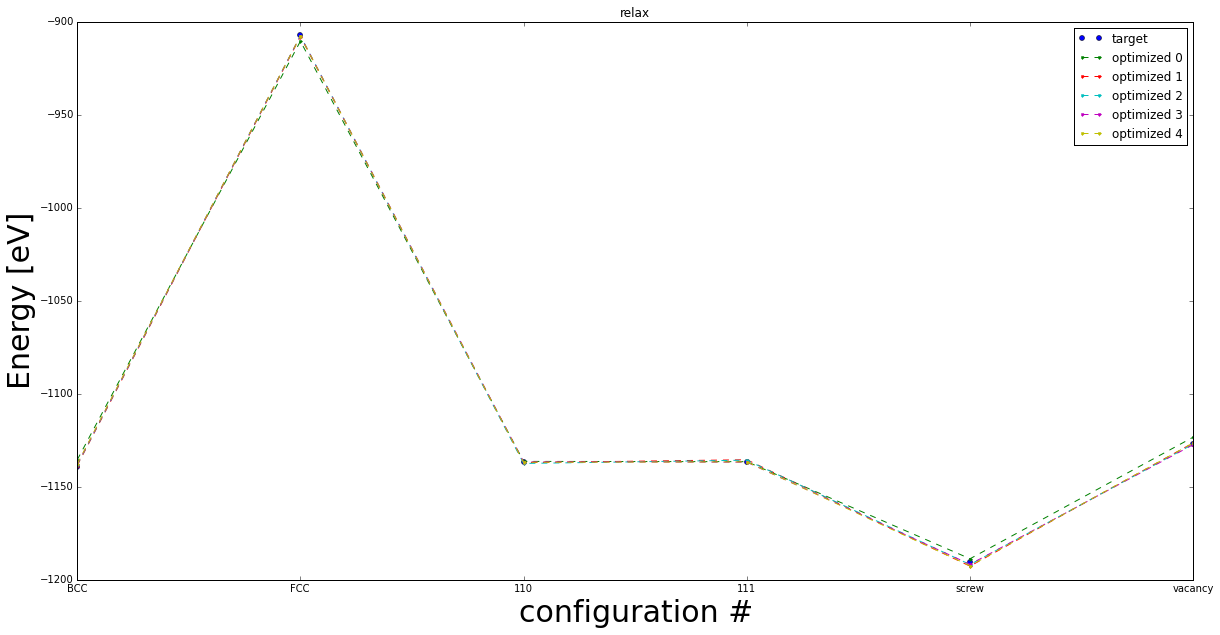

In [347]:
# plot relax
x_ticks = ([0, 1, 2, 3, 4, 5], ['BCC', 'FCC','110','111', 'screw', 'vacancy'])
slice_end = len(x_ticks[0])
select = slice(0, slice_end, None)
plot_udif(targets, stats, 'relax', optimal_params, select=select, x_ticks=x_ticks)

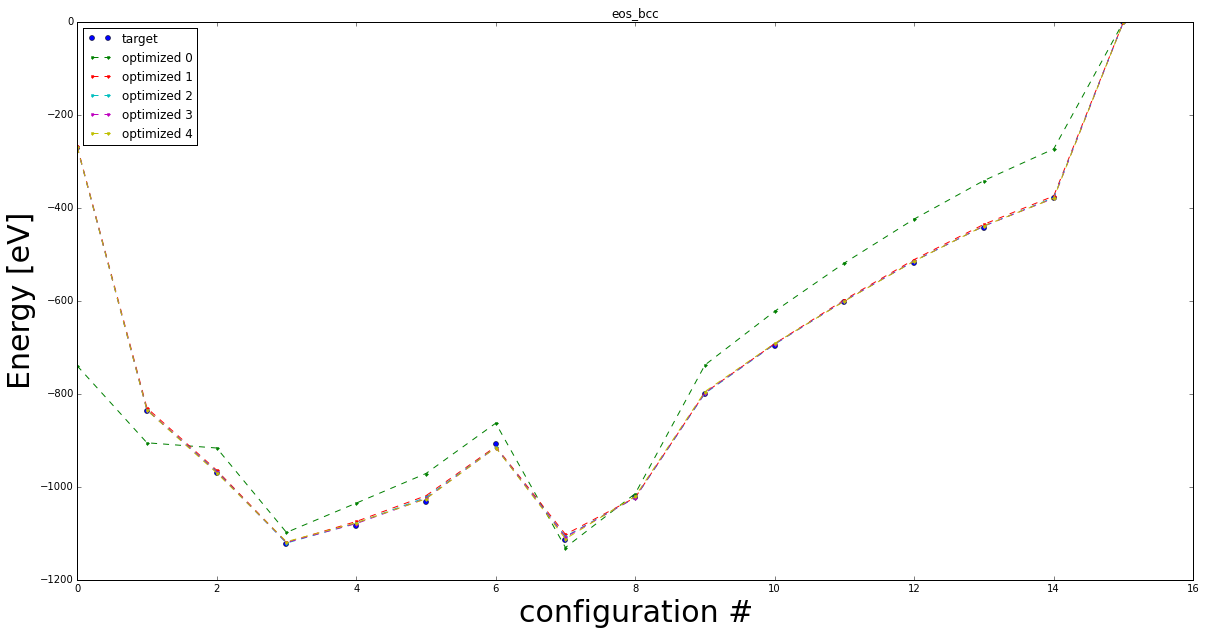

In [348]:
# plot bcc EOS
select = [10, 11, 6, 3, 4, 5, 7, 2, 1, 12, 13, 14, 15, 16, 17, 18]
x_lim = (2, 8)
y_lim = (-9.0, -7.0)
plot_udif(targets, stats, 'eos_bcc', optimal_params, select=select)#, x_lim=x_lim, y_lim=y_lim)

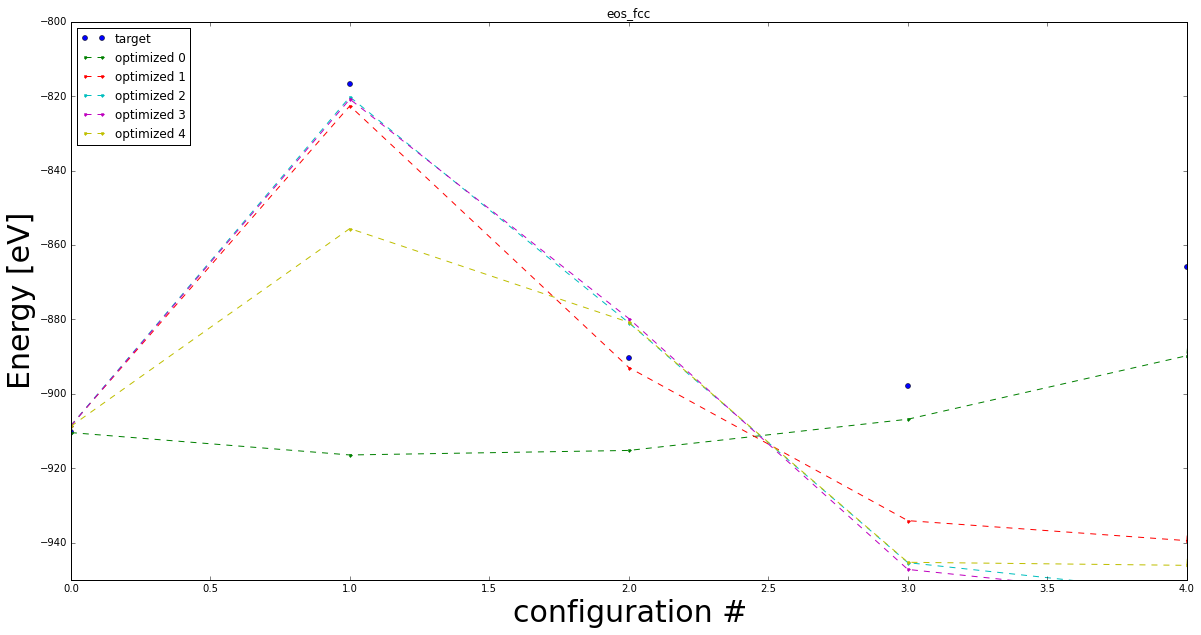

In [349]:
# plot fcc EOS
select = [1, 2, 3, 0, 5, 6, 7, 4]
x_lim = (0, 4)
y_lim = (-950, -800)
plot_udif(targets, stats, 'eos_fcc', optimal_params, x_lim=x_lim, y_lim=y_lim)#, select=select)

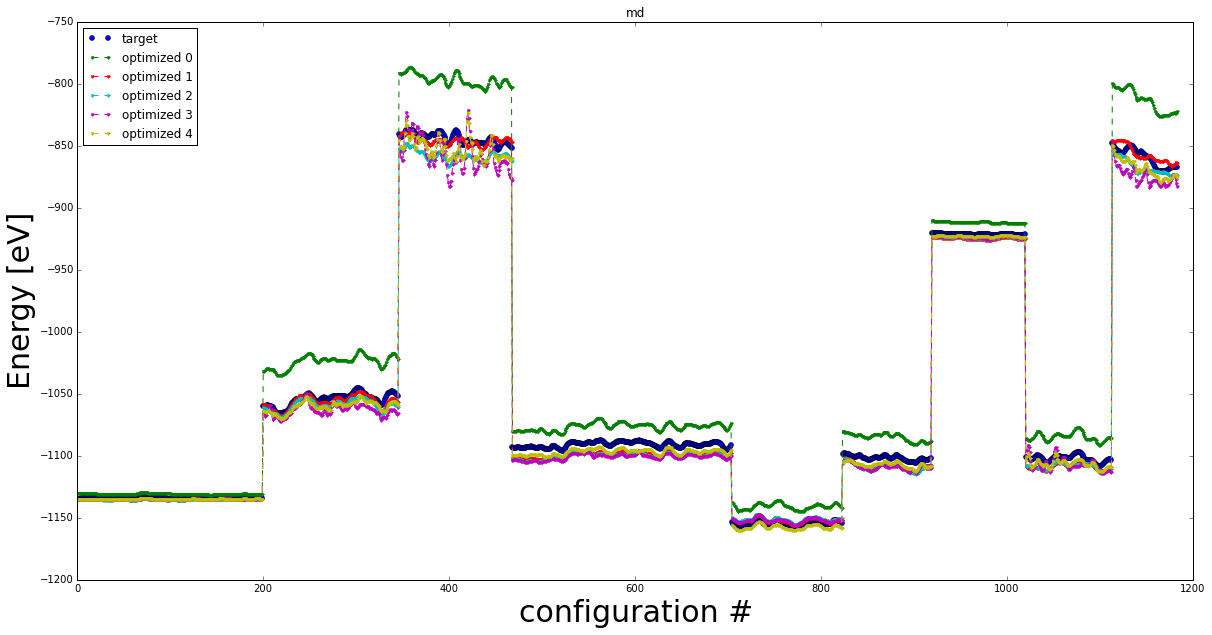

In [350]:
# plot MD trajectories
x_lim = (380,420)
x_lim = (0,200)
y_lim = (-900,-780)
y_lim = (-1140,-1125)

plot_udif(targets, stats, 'md', optimal_params)#, x_lim=x_lim, y_lim=y_lim)

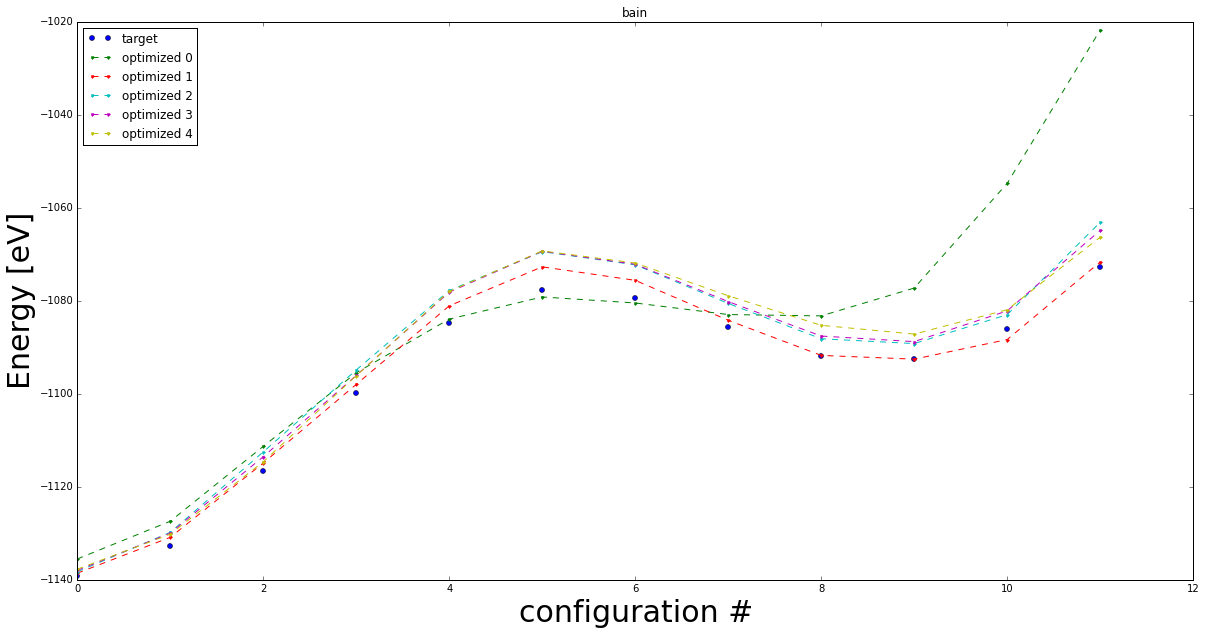

In [351]:
# plot MD trajectories
x_lim = (380,420)
y_lim = (-900,-780)
plot_udif(targets, stats, 'bain', optimal_params)#, x_lim=x_lim, y_lim=y_lim)

In [ ]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['eos_bcc']['xyz']])[:-1]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, targets, utot_EAM_per_box, [5])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[2][:])
        print('Model:', opti_out[2][:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[2][:-1]))/nat)
        plt.plot(np.array(targ_out[2][:-1])/nat, 'o', label='target'+str(i), markersize=10)
        
    #if params_uopt[0] > 0.6e-3:
    #    continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot(np.array([o for o in opti_out[2][:-1]])/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

In [ ]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['eos_fcc']['xyz']])[:-1]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, targets, utot_EAM_per_box, [5])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-3][:])
        print('Model:', opti_out[-3][:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[3][:-1]))/nat)
        plt.plot(np.array(targ_out[3][:-1])[[2, 3, 0, 1, 4, 5, 6, 7]]/nat, 'o', label='target'+str(i), markersize=10)
        
    #if params_uopt[0] > 0.6e-3:
    #    continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot(np.array([o for o in opti_out[3][:-1]])[[2, 3, 0, 1, 4, 5, 6, 7]]/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

In [ ]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['eos_fcc']['xyz']])[:-1]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, targets, utot_EAM, [9])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-1][:])
        print('Model:', opti_out[-1][:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[-1][:-1]))/nat)
        plt.plot(np.array(targ_out[-1][:-1])[[2, 3, 0, 1, 4, 5, 6, 7, 8]]/nat, 'o', label='target'+str(i), markersize=10)
        
    #if params_uopt[0] > 0.6e-3:
    #    continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot( np.array([o for o in opti_out[-1][:-1]])[[2, 3, 0, 1, 4, 5, 6, 7, 8]]/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

In [ ]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['md']['xyz']])[:]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, targets, utot_EAM_per_box,[5])
    #plt.title('Selected configurations at 0K')
    if i == 0:
        #print('Targ:', targ_out[0][:])
        #print('Model:', opti_out[0][:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[0][:]))/nat)
        #plt.plot(np.array(targ_out[0][:])/nat, 'o', label='target'+str(i), markersize=10)
        plt.plot(np.array(targ_out[0][:]), 'o', label='target'+str(i), markersize=5)

        
    #if params_uopt[0] > 0.6e-3:
    #    continue
    #if i != 1:# and i != 12:
    #    continue
    print(i, params_uopt[0])

    #print('Opti:', [o for o in opti_out[-1][:-1]])
    #plt.plot(np.array([o for o in opti_out[0][:]])/nat, 'x--', label='optimized '+str(i))
    plt.plot(np.array([o for o in opti_out[0][:]]), '--', label='optimized '+str(i), lw=1.0)

#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]', fontsize=30)
plt.xlabel('configuation #', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.533)
#plt.ylim(-8.9, -8.35)

#plt.ylim(-1075,-1035)
#plt.ylim(-1000,-900)
#plt.ylim(-950,-900)
#plt.ylim(-1136,-1133)
plt.ylim(-1180,-800)
plt.xlim(0,820)
#plt.xlim(847,990)

#plt.ylim(-1180,-800)

plt.legend(fontsize=30)
#plt.savefig(plt.savefig(os.path.join(working, 'bcc_300.png')))

In [ ]:
for i, params_uopt in enumerate(optimal_parameters):
    if params_uopt[0] > 1.1e-3:
        continue
    print(i, params_uopt[0], '\n', params_uopt[1])

In [ ]:
stats_opts[it]['hyperparams']

In [ ]:
pars_out = {}
pars_out['pair_nodes'] = stats_opts[it]['hyperparams']
pars_out['mb_node'] = 9
pars_out['params'] = [optimal_parameters[0]]

In [ ]:
optimal_list = []

#with open(os.path.join(working, 'pars_out.pickle'), 'rb') as fi:
#    optimal_list = pickle.load(fi)

#if type(optimal_list) != list:
#    optimal_list = [optimal_list]

optimal_list.append(pars_out)

with open(os.path.join(working, 'pars_out.pickle'), 'wb') as fo:
    pickle.dump(optimal_list, fo, protocol=2)

In [ ]:
with open(os.path.join(working, 'pars_out.pickle'), 'rb') as fi:
    optimal_list = pickle.load(fi)

In [ ]:
optimal_list

In [ ]:
# Total pair potential
pos = targ_ready['relax']['xyz'][0]
bx = targ_ready['relax']['box'][0]
rr, rx = pair_dist_cutoff(pos, bx, 5.5)

In [ ]:
# embedding function
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Cohesive potential (cubic splines - same form as V)
phi = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

rho = lambda r, aa, kk: sum([a*(rk - r)**3 for a, rk in zip(aa, kk) if r < rk and r > 0.01])

In [ ]:
optimal_list[-1]['params'][0][1]

In [ ]:
#optimal_parameters.append(tuple([output[1:], params_uopt]))
pair_y = optimal_list[-1]['params'][0][1][2:]
par = optimal_list[-1]['params'][0][1][:2]
many_y = [par[0], 0.0, par[1]]
V_x_r = optimal_list[-1]['pair_nodes'] #stats_opt['hyperparams']
rho_x_r = [V_x_r[optimal_list[-1]['mb_node']]] #stats_opt['hyperparams'][4:5]
rho_x_a = [1.0]

In [ ]:
pair_y, many_y, V_x_r, rho_x_r

In [ ]:
ene = []
for a in np.linspace(0.5, 2.0, 101):
    z = a*rr
    u_pair = 0.5*np.sum([V(x, pair_y, V_x_r) for x in z.flatten() if x > 0.1])

    u_many = 0.0
    for i in range(z.shape[0]):
        d = np.sum([phi(x, rho_x_a, rho_x_r) for x in z[i] if x > 0.1])
        u_many += F(d, many_y)

    ene.append([a, u_pair, u_many, u_pair+u_many])

ene = np.array(ene)

In [ ]:
#plt.plot(ene[:,0], ene[:,1]/54, label='pair')
#plt.plot(ene[:,0], ene[:,2]/54, label='manybody')
plt.title('Equation of state (T=0K)')
plt.plot(ene[:,0]*2.74, [universal_eos(x, 'W') for x in ene[:,0]], label='universal EOS')
plt.plot(ene[:,0]*2.74, ene[:,3]/128, label='u-total')
plt.hlines(0.0,0.5,6.0,lw=1)
plt.legend()
plt.xlim(2.0, 5.75)
plt.xlim(2.6, 2.85)
plt.ylim(-10,10)
plt.ylim(-9.,-8.5)

plt.xlabel('x')
plt.ylabel(r'U')

In [ ]:
#optimal_parameters.append(tuple([output[1:], params_uopt]))
pair_y = optimal_list[-1]['params'][0][1][2:]
par = optimal_list[-1]['params'][0][1][:2]
many_y = [par[0], 0.0, par[1]]
V_x_r = optimal_list[-1]['pair_nodes'] #stats_opt['hyperparams']
rho_x_r = [V_x_r[optimal_list[-1]['mb_node']]] #stats_opt['hyperparams'][4:5]
rho_x_a = [1.0]

In [ ]:
pair_y, many_y

In [ ]:
print(V_x_r)
print((0.011166762673644966, np.array([-1.43897524e+00,  3.68357996e-06, -4.10835857e+01,  1.01633094e+02,
       -9.73045925e+01,  3.38437384e+01, -3.58251075e+00, -1.67919252e+00,
        8.65702805e-01,  2.65888291e-01, -1.20777286e+00,  4.75855652e-01])))

In [ ]:
pair_a = optimal_list[-1]['params'][0][1][2:]#pars_in1[2:]
pair_r = optimal_list[-1]['pair_nodes']

rho_a = [1.0]
rho_r = [pair_r[optimal_list[-1]['mb_node']]]

par = optimal_list[-1]['params'][0][1][:2]
many_a = [par[0], 0.0, par[1]]

In [ ]:
pair_a, pair_r, rho_r, many_a, par

In [ ]:
# Ranges of densities and separations

nr = 5000
rcut = pair_r[-1]#stats_opt['hyperparams'][-1]
dr = rcut/nr

rhomax = 12.0*phi(1.5, rho_a, rho_r)
print('rhomax:', rhomax)
rhomax = 1000.0
nrho = 5000
drho = rhomax/nrho

ri = 1.0
ro = 2.0

# W properties
na = 74
ma = 183.84
lc = 3.1653
alat = 'bcc'

# System composition
n_el = 1
el_name = ['W']

In [ ]:
def u_trans(r, unucl, ueq, ri=1.0, ro=2.0):
    """Transition between the core and equillibrium potentials"""
    if r < ri:
        return unucl
    elif r < ro:
        x = (ro + ri - 2*r)/(ro - ri)
        eta = 3/16*x**5 - 5/8*x**3 + 15/16*x + 1/2
        return ueq + eta*(unucl - ueq)
    else:
        return ueq

In [ ]:
# prepare lists of values
dens = np.linspace(0., rhomax-drho, nrho, endpoint=True)
r = np.linspace(0., rcut-dr, nr, endpoint=True)
r2 = np.linspace(0., rcut, 201)

fembd = [F(d, many_a) for d in dens] # W
edens = np.array([phi(x, rho_a, rho_r) for x in r])

# 1. Cubic spline for r > r_o
f_outer = [V(x, pair_a, pair_r) for i, x in enumerate(r)]
# 2. Repulsive core for r < r_i (precalculate up to r_o)
f_inner = [0.0] + [u_core(x) for x in r[1:]]
# 3. Transition region for r_i < r < r_o
fpair = [x*u_trans(x, f_inner[i], f_outer[i]) for i, x in enumerate(r)]
#fpair = f_outer

In [ ]:
# LAMMPS format
pot_path = '../sim/potentials'

with open(os.path.join(pot_path, 'W_lv_bccfcc.eam.fs'), 'w') as fo:
    
    # Comment section
    fo.write('Comment 1\n')
    fo.write('Comment 2\n')
    fo.write('Comment 3\n')
    
    # Number of elements
    fo.write(f"{n_el:5d} ")
    for i in range(n_el):
        fo.write(f"{el_name[i]:2}")
    fo.write("\n")
    
    # number of grid points, step size, and cutoff
    fo.write(f"{nrho:5d}{drho:24.16e}{nr:5d}{dr:24.16e}{rcut:24.16e}\n")
    
    # atomic number, mass, lattice size, lattice type
    fo.write(f"{na:5d} {ma:14.4f} {lc:14.4f} {alat:10}\n")
    
    # Embeding function
    for i in range(nrho//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fembd[i*4:i*4+4]))
    
    # Electronic density
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*edens[i*4:i*4+4]))
        
    # Pair potential
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fpair[i*4:i*4+4]))